In [1]:
import numpy as np
import b18_routines as b18
from scipy import optimize
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, Math

In [2]:
verbose = 1
%config Completer.use_jedi = False  #Speeds up tab autocomplete in notebooks

In [3]:
# Set up input parameters that will be fixed throughout
a, b, c = 0.1  ,-14054, 0.0 # Dissociation   #TABLE S2 of B18
a, b, c = -1.98, -4402, 0.0 # Exchange

#2 sets of values for dissolution from '16 and '18 papers
a_Mg_B16, b_Mg_B16, c_Mg_B16 = 1.23, -18816.0, 0.0
a_Mg_B18, b_Mg_B18, c_Mg_B18 = 1.06  ,-12842 , 0.0 # Dissolution - use this for now. 

a_Mg_OS, b_Mg_OS, c_Mg_OS = 0.1,-10851,0.0
a_Si_OS, b_Si_OS, c_Si_OS = 1.3,-13500,0.0  # Fischer 2015
a_O_OS , b_O_OS , c_O_OS  = 0.6,-3800 ,22.0 # Fischer 2015

In [4]:
# These params may want to change...
Tcmb   = np.linspace(4900,4100,101)

core_mass_fractions = [0.03, 0.03, 0]
XO_c, XSi_c, XMgO_c = b18.mass2moleconc_core(*core_mass_fractions) #Mass fractions of core O,Si,MgO in mole fractions

XS_c = 0.0000
XC_c = 0.0000
XFe_c= 1-XO_c-XSi_c-XMgO_c
XMgO_m = np.array([0.1, 0.5])
XFeO_m = np.array([0.1, 0.3])

In [5]:
# Compare logKd values form different studies
logKd_MgO_B16 = b18.logKd_ideal(a_Mg_B16, b_Mg_B16, c_Mg_B16, Tcmb)
logKd_MgO_B18 = b18.logKd_ideal(a_Mg_B18, b_Mg_B18, c_Mg_B18, Tcmb)
logKd_MgO_O16 = b18.logKd_ideal(a_Mg_OS , b_Mg_OS , c_Mg_OS , Tcmb)

logKd_O       = b18.logKd_ideal(a_O_OS , b_O_OS , c_O_OS , Tcmb) #From Fischer and used in Mittal & O16
logKd_Si      = b18.logKd_ideal(a_Si_OS, b_Si_OS, c_Si_OS, Tcmb) #From Fischer and used in Mittal & O16

## Calculate activity coefficients ($\gamma$)

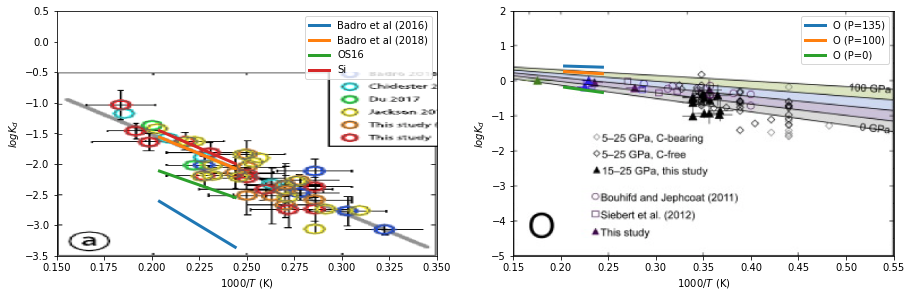

In [6]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,4.5))

fischer_a = plt.imread('Fischer_2016_fig6a.png')
fischer_b = plt.imread('Fischer_2016_fig6b.png')
#ax1.imshow(fischer_a, extent=(0.15,0.55,-5,2), aspect='auto') #Plot fischer plot below

badro_1a = plt.imread('badro_18_fig1a.png')
ax1.imshow(badro_1a, extent=(0.15,0.35,-3.5,-0.5), aspect='auto')

ax1.set_ylim([-3.5,0.5]) # Fischer Fig 6
ax1.set_xlabel("$1000/T$ (K)")
ax1.set_ylabel("$log K_d$")
ax1.set_xlim([0.15,0.35])
ax1.plot(1000.0/Tcmb, logKd_MgO_B16, lw=3, label="Badro et al (2016)")
ax1.plot(1000.0/Tcmb, logKd_MgO_B18, lw=3, label="Badro et al (2018)")
ax1.plot(1000.0/Tcmb, logKd_MgO_O16, lw=3, label="OS16")
ax1.plot(1000.0/Tcmb, logKd_Si,      lw=3, label="Si")
ax1.legend()

ax2.imshow(fischer_b, extent=(0.15,0.55,-5,2), aspect='auto')
#ax2.set_ylim([-5,2]) # Fischer Fig 6
ax2.set_xlabel("$1000/T$ (K)")
ax2.set_ylabel("$log K_d$")
ax2.plot(1000.0/Tcmb, logKd_O, lw=3, label="O (P=135)")
ax2.plot(1000/Tcmb, b18.logKd_ideal(a_O_OS , b_O_OS , c_O_OS , Tcmb, P=100), lw=3, label='O (P=100)')
ax2.plot(1000/Tcmb, b18.logKd_ideal(a_O_OS , b_O_OS , c_O_OS , Tcmb, P=0),   lw=3, label='O (P=0)')
ax2.legend()
plt.show()

In [7]:
#XFeO_F15_DL = b18.O_dissociation(XFe_c, XO_c,10**logKd_O)
#cO_c_B16_E, cSi_c_B16_E, cMg_c_B16_E = b18.mole2massconc_core(XO_c, XSi_c, XMg_B16_E)

#XSiO2_F15_E  = b18.Si_exchange(XSi_c, XFe_c, XFeO_F15_DL, 10**logKd_Si)


Note that Figure 6 plots from Fischer 2016 are plotted in the background above

In [8]:
# Find the eq conc at each T for just MgO equilibrium

cMg_c_B16_E  ,cMg_c_B18_E  ,cMg_c_O16_E = np.zeros([len(XMgO_m),len(XFeO_m),len(Tcmb)]), np.zeros([len(XMgO_m), len(XFeO_m),len(Tcmb)]), np.zeros([len(XMgO_m), len(XFeO_m),len(Tcmb)])
cMg_c_B16_DLi,cMg_c_B18_DLi,cMg_c_O16_DLi = np.zeros([len(XMgO_m),len(XFeO_m),len(Tcmb)]), np.zeros([len(XMgO_m), len(XFeO_m),len(Tcmb)]), np.zeros([len(XMgO_m), len(XFeO_m),len(Tcmb)])
cMg_c_B16 = np.zeros([len(XMgO_m),len(XFeO_m),len(Tcmb)])

m = 0
for XMgO in XMgO_m:
    f = 0
    for XFeO in XFeO_m:
        
        XSiO2 = 1.0 -  XMgO - XFeO
        
        XMg_B16_E  = b18.Mg_exchange(XMgO, XFe_c, XFeO, 10**logKd_MgO_B16, 0.0, 0.0)
        XMg_B18_E  = b18.Mg_exchange(XMgO, XFe_c, XFeO, 10**logKd_MgO_B18, 0.0, 0.0)
        XMg_O16_E  = b18.Mg_exchange(XMgO, XFe_c, XFeO, 10**logKd_MgO_O16, 0.0, 0.0)
        cO_c_B16_E, cSi_c_B16_E, cMg_c_B16_E[m,f] = b18.mole2massconc_core(XO_c, XSi_c, XMg_B16_E)
        cO_c_B18_E, cSi_c_B18_E, cMg_c_B18_E[m,f] = b18.mole2massconc_core(XO_c, XSi_c, XMg_B18_E)
        cO_c_O16_E, cSi_c_O16_E, cMg_c_O16_E[m,f] = b18.mole2massconc_core(XO_c, XSi_c, XMg_O16_E)

        XMg_B16_DC = b18.Mg_dissociation(XMgO, XO_c, 10**logKd_MgO_B16 , 0.0, 0.0)
        XMg_B18_DC = b18.Mg_dissociation(XMgO, XO_c, 10**logKd_MgO_B18 , 0.0, 0.0)
        XMg_O16_DC = b18.Mg_dissociation(XMgO, XO_c, 10**logKd_MgO_O16, 0.0, 0.0)

        XMg_B16_DLi = b18.Mg_dissolution(XMgO, 10**logKd_MgO_B16, 0.0, 0.0)
        XMg_B18_DLi = b18.Mg_dissolution(XMgO, 10**logKd_MgO_B18, 0.0, 0.0)
        XMg_O16_DLi = b18.Mg_dissolution(XMgO, 10**logKd_MgO_O16, 0.0, 0.0)
        cO_c_B16_DLi, cSi_c_B16_DLi, cMg_c_B16_DLi[m,f] = b18.mole2massconc_core(XO_c, XSi_c, XMg_B16_DLi)
        cO_c_B18_DLi, cSi_c_B18_DLi, cMg_c_B18_DLi[m,f] = b18.mole2massconc_core(XO_c, XSi_c, XMg_B18_DLi)
        cO_c_O16_DLi, cSi_c_O16_DLi, cMg_c_O16_DLi[m,f] = b18.mole2massconc_core(XO_c, XSi_c, XMg_O16_DLi)

        # Making sure we can reproduce B16 Fig 1b
        XMg_B16 = b18.Mg_dissolution_B16(XMgO, 10**logKd_MgO_B16)
        cO_c_B16, cSi_c_B16, cMg_c_B16[m,f] = b18.mole2massconc_core(0.0, 0.0, XMg_B16)
                
        f = f + 1
    m = m + 1

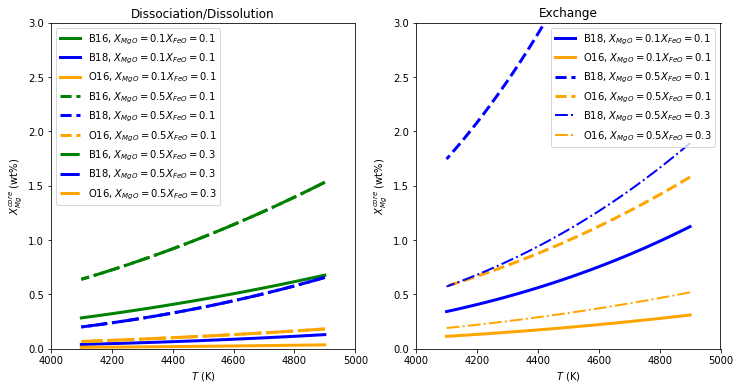

In [13]:
fig, (ax2,ax3) = plt.subplots(1,2,figsize=(12,6))

#badro_1b = plt.imread('badro_16_fig1b.png')
#ax2.imshow(badro_1b, extent=(3000,7000,0,12), aspect='auto')
#badro_4a = plt.imread('badro_18_fig4a.png')
#ax2.imshow(badro_4a, extent=(4000,5000,0,1.5), aspect='auto')

ax2.set_title("Dissociation/Dissolution")
ax2.set_xlim([4000,5000])
ax2.set_ylim([0   ,3   ])
ax2.set_xlabel("$T$ (K)")
ax2.set_ylabel("$X_{Mg}^{core}$ (wt%)")
ax2.plot(Tcmb, cMg_c_B16[0,0]*100    , label='B16, $X_{MgO} = $'+str(XMgO_m[0])+'$X_{FeO} = $'+str(XFeO_m[0]), color="g", lw=3)
ax2.plot(Tcmb, cMg_c_B18_DLi[0,0]*100, label='B18, $X_{MgO} = $'+str(XMgO_m[0])+'$X_{FeO} = $'+str(XFeO_m[0]), color="b", lw=3)
ax2.plot(Tcmb, cMg_c_O16_DLi[0,0]*100, label='O16, $X_{MgO} = $'+str(XMgO_m[0])+'$X_{FeO} = $'+str(XFeO_m[0]), color='orange', lw=3)
ax2.plot(Tcmb, cMg_c_B16[1,0]*100    , label='B16, $X_{MgO} = $'+str(XMgO_m[1])+'$X_{FeO} = $'+str(XFeO_m[0]), color="g", lw=3, ls="--")
ax2.plot(Tcmb, cMg_c_B18_DLi[1,0]*100, label='B18, $X_{MgO} = $'+str(XMgO_m[1])+'$X_{FeO} = $'+str(XFeO_m[0]), color="b", lw=3, ls="--")
ax2.plot(Tcmb, cMg_c_O16_DLi[1,0]*100, label='O16, $X_{MgO} = $'+str(XMgO_m[1])+'$X_{FeO} = $'+str(XFeO_m[0]), color='orange', lw=3, ls="--")
ax2.plot(Tcmb, cMg_c_B16[1,1]*100    , label='B16, $X_{MgO} = $'+str(XMgO_m[1])+'$X_{FeO} = $'+str(XFeO_m[1]), color="g", lw=3, ls="-.")
ax2.plot(Tcmb, cMg_c_B18_DLi[1,1]*100, label='B18, $X_{MgO} = $'+str(XMgO_m[1])+'$X_{FeO} = $'+str(XFeO_m[1]), color="b", lw=3, ls="-.")
ax2.plot(Tcmb, cMg_c_O16_DLi[1,1]*100, label='O16, $X_{MgO} = $'+str(XMgO_m[1])+'$X_{FeO} = $'+str(XFeO_m[1]), color='orange', lw=3, ls="-.")
ax2.legend()

ax3.set_title("Exchange")
ax3.set_xlim([4000,5000])
ax3.set_ylim([0   ,3   ])
ax3.set_xlabel("$T$ (K)")
ax3.set_ylabel("$X_{Mg}^{core}$ (wt%)")
ax3.plot(Tcmb, cMg_c_B18_E[0,0]*100, label='B18, $X_{MgO} = $'+str(XMgO_m[0])+'$X_{FeO} = $'+str(XFeO_m[0]), color="b", lw=3)
ax3.plot(Tcmb, cMg_c_O16_E[0,0]*100, label='O16, $X_{MgO} = $'+str(XMgO_m[0])+'$X_{FeO} = $'+str(XFeO_m[0]), color='orange', lw=3)
ax3.plot(Tcmb, cMg_c_B18_E[1,0]*100, label='B18, $X_{MgO} = $'+str(XMgO_m[1])+'$X_{FeO} = $'+str(XFeO_m[0]), color="b", lw=3, ls="--")
ax3.plot(Tcmb, cMg_c_O16_E[1,0]*100, label='O16, $X_{MgO} = $'+str(XMgO_m[1])+'$X_{FeO} = $'+str(XFeO_m[0]), color='orange', lw=3, ls="--")
ax3.plot(Tcmb, cMg_c_B18_E[1,1]*100, label='B18, $X_{MgO} = $'+str(XMgO_m[1])+'$X_{FeO} = $'+str(XFeO_m[1]), color="b", lw=2, ls="-.")
ax3.plot(Tcmb, cMg_c_O16_E[1,1]*100, label='O16, $X_{MgO} = $'+str(XMgO_m[1])+'$X_{FeO} = $'+str(XFeO_m[1]), color='orange', lw=2, ls="-.")
ax3.legend()
plt.show()

Note that fig1b from Badro 2016 and fig 4a from Badro 2018 are plotted in the background